In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.utils.image_utils import reshape_on_mask

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
ssao = SingleStageAO('calib_amplitude')
KL,_ = ssao.define_KL_modes(ssao.dm,zern_modes=2)

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Starting modal basis generation...
Input shapes: pupil_mask=(140, 140), influence_functions=(820, 15361)
Step 1: Removing modes from influence functions...
Generated Zernike modes shape: (2, 140, 140)
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 20.17816162109375
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...
Step 5: Calculating modal basis...
Step 6: Adding Zernike modes to basis...
Final shapes: kl_basis=(819, 15361), m2c=(820, 819)


In [3]:
lambdaInM = ssao.pyr.lambdaInM
amp = 5e-9
rMod = 5.0

ssao.pyr.set_modulation_angle(modulationAngleInLambdaOverD=rMod)
Rec,IM = ssao.compute_reconstructor(ssao.sc, KL, lambdaInM=lambdaInM, ampsInM=amp, save_prefix=f'rMod{rMod:1.0f}_amp{amp*1e+9:1.0f}nm_')

Modulating 5 [lambda/D] with 36 modulation steps
Calibration amplitudes: 5-0.8 [nm] (42-7 [mrad])


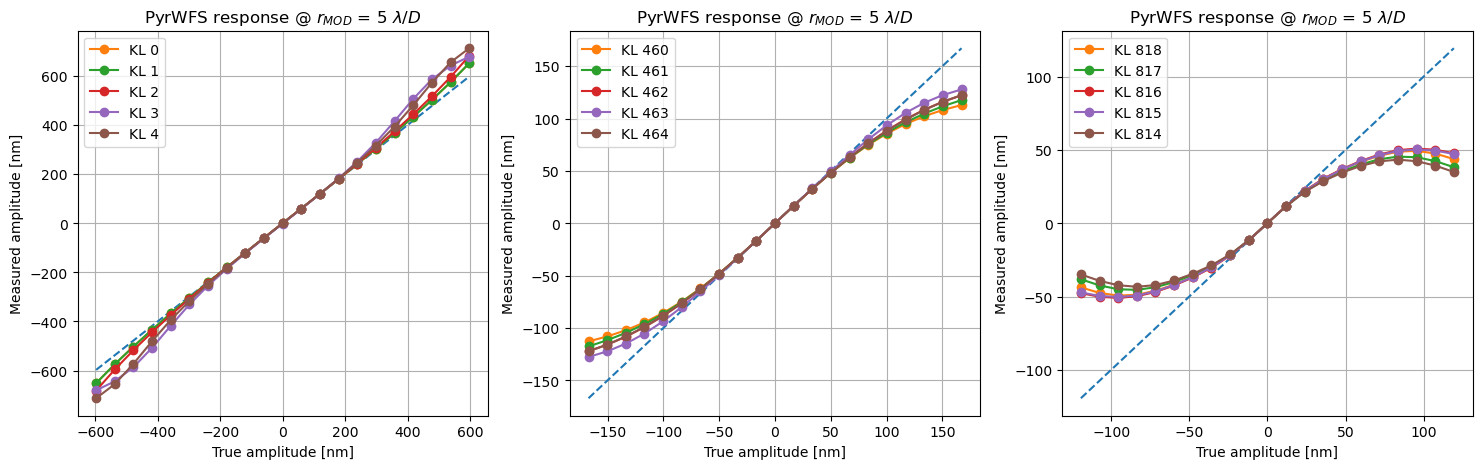

In [4]:
# Linearity check
rad2nm = lambdaInM/(2*xp.pi)*1e+9
Nmodes = 5
nRecModes = xp.shape(Rec)[0]

N = 21
amp_vec = xp.linspace(-5,5,N,endpoint=True)
mid_amp_vec = xp.linspace(-1.4,1.4,N,endpoint=True)
low_amp_vec = xp.linspace(-1,1,N,endpoint=True)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(amp_vec)*rad2nm,'--')
plt.subplot(1,3,2)
plt.plot(xp.asnumpy(mid_amp_vec)*rad2nm,xp.asnumpy(mid_amp_vec)*rad2nm,'--')
plt.subplot(1,3,3)
plt.plot(xp.asnumpy(low_amp_vec)*rad2nm,xp.asnumpy(low_amp_vec)*rad2nm,'--')

lambdaOverD = lambdaInM/ssao.pupilSizeInM
field_amp = 1-ssao.cmask


for j in range(Nmodes):

    zid = j
    meas_amp = xp.zeros_like(amp_vec)

    mid_zid = 460 + j #nRecModes//2 + Nmodes//2 - j
    mid_meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j - 1
    rev_meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[zid],ssao.cmask)*amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        meas_amp[k] = modes[zid]

        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[mid_zid],ssao.cmask)*mid_amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        mid_meas_amp[k] = modes[mid_zid]

        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[rev_zid],ssao.cmask)*low_amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        rev_meas_amp[k] = modes[rev_zid]
    
    plt.subplot(1,3,1)
    plt.plot(xp.asnumpy(amp_vec)*rad2nm, xp.asnumpy(meas_amp)*rad2nm,'-o', label=f'KL {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude [nm]')
    plt.ylabel('Measured amplitude [nm]')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 5 $\lambda/D$')
    plt.grid(True)

    plt.subplot(1,3,2)
    plt.plot(xp.asnumpy(mid_amp_vec)*rad2nm, xp.asnumpy(mid_meas_amp)*rad2nm,'-o', label=f'KL {mid_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude [nm]')
    plt.ylabel('Measured amplitude [nm]')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 5 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,3,3)
    plt.plot(xp.asnumpy(low_amp_vec)*rad2nm, xp.asnumpy(rev_meas_amp)*rad2nm,'-o', label=f'KL {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude [nm]')
    plt.ylabel('Measured amplitude [nm]')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 5 $\lambda/D$')
    plt.grid(True)

In [5]:
def get_error_from_mode_amp(amp, mode, mode_id, Rec):
    input_field = field_amp*xp.exp(1j*reshape_on_mask(mode,ssao.cmask)*amp, dtype=ssao.cdtype)
    slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
    modes = Rec @ slopes
    meas_amp = modes[mode_id]
    rel_err = abs(amp-meas_amp)/amp
    abs_err = abs(amp-meas_amp)
    return rel_err, abs_err

def find_sat_amps_per_rMod(calib_amp, min_amp, rMod, maxErrInNm=100):

    print('Computing reconstructor ...')
    ssao.pyr.set_modulation_angle(modulationAngleInLambdaOverD=rMod)
    ampInM = calib_amp*lambdaInM/(2*xp.pi)
    Rec,_ = ssao.compute_reconstructor(ssao.sc, KL, lambdaInM=lambdaInM, ampsInM=ampInM, save_prefix=f'rMod{rMod:1.0f}_amp{ampInM*1e+9:1.0f}nm_')

    sat_amp = xp.ones(nRecModes)*min_amp

    for j in range(nRecModes):
        mode_id = -j-1
        print(f'\rMode {j:1.0f}/{nRecModes:1.0f}',end='\r',flush=True)
        start_amp = sat_amp[mode_id+1]*0.9
        true_amp = start_amp.copy()
        mode = KL[mode_id,:]
        rel_err, abs_err = get_error_from_mode_amp(true_amp, mode, mode_id, Rec)

        while rel_err < 0.1 and abs_err < maxErrInNm*1e-9*(2*xp.pi)/lambdaInM:
            true_amp += 0.1*min_amp
            rel_err, abs_err = get_error_from_mode_amp(true_amp, mode, mode_id, Rec)
        
        sat_amp[mode_id] = true_amp - 0.1*min_amp
        # print(true_amp, nRecModes+mode_id)

    return sat_amp

In [7]:
rMod3_sat_amp = find_sat_amps_per_rMod(calib_amp=0.02, min_amp=5/rad2nm, rMod=3.0)

Computing reconstructor ...
Modulating 3 [lambda/D] with 20 modulation steps


In [ ]:
# min_amp = 0.2
# sat_amp = xp.ones(nRecModes)*min_amp

# def get_error_from_mode_amp(amp, mode):
#     input_field = field_amp*xp.exp(1j*reshape_on_mask(mode,ssao.cmask)*amp, dtype=ssao.cdtype)
#     slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
#     modes = Rec @ slopes
#     meas_amp = modes[mode_id]
#     rel_err = abs(amp-meas_amp)/amp
#     abs_err = abs(amp-meas_amp)
#     return rel_err, abs_err

# for j in range(nRecModes):
#     mode_id = -j-1
#     print(f'\rMode {j:1.0f}/{nRecModes:1.0f}',end='\r',flush=True)
#     start_amp = sat_amp[mode_id+1]*0.9
#     true_amp = start_amp.copy()
#     mode = KL[mode_id,:]
#     rel_err, abs_err = get_error_from_mode_amp(true_amp, mode)

#     while rel_err < 0.1 and abs_err < maxErrInNm*1e-9*(2*xp.pi)/lambdaInM:
#         true_amp += 0.1*start_amp
#         rel_err, abs_err = get_error_from_mode_amp(true_amp, mode)
    
#     sat_amp[mode_id] = true_amp - 0.1*start_amp
#     # print(true_amp, nRecModes+mode_id)



In [8]:
rMod5_sat_amp = find_sat_amps_per_rMod(calib_amp=10/rad2nm, min_amp=5/rad2nm, rMod=5.0)
rMod1_sat_amp = find_sat_amps_per_rMod(calib_amp=3/rad2nm, min_amp=5/rad2nm, rMod=1.0)

Computing reconstructor ...
Modulating 5 [lambda/D] with 36 modulation steps
Calibration amplitudes: 10-1.6 [nm] (84-13 [mrad])
Computing reconstructor ...
Modulating 1 [lambda/D] with 8 modulation steps
Calibration amplitudes: 3-0.5 [nm] (25-4 [mrad])


In [9]:

rMod0_sat_amp = find_sat_amps_per_rMod(calib_amp=1/rad2nm, min_amp=5/rad2nm, rMod=0.0)

Computing reconstructor ...
Modulating 0 [lambda/D] with 0 modulation steps
Calibration amplitudes: 1-0.2 [nm] (8-1 [mrad])


In [10]:
def radial_order(i_mode):
    noll = i_mode + 2
    return xp.ceil(-3.0/2.0+xp.sqrt(1+8*noll)/2.0)

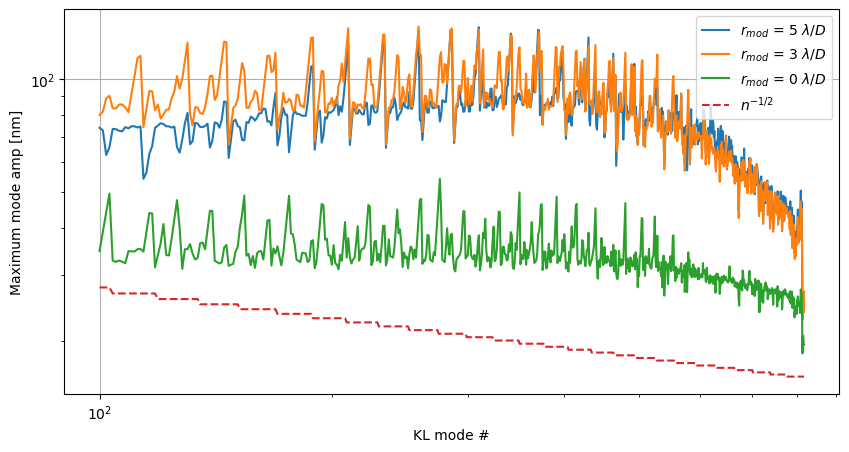

: 

In [ ]:
Nmin = 100

modes = xp.arange(Nmin,len(rMod0_sat_amp))
rad_orders = radial_order(modes)

power_law = 100*rad_orders**(-1/2)
power_law2 = 10000*rad_orders**(-2)

plt.figure(figsize=(10,5))
plt.plot(xp.asnumpy(modes),xp.asnumpy(rMod5_sat_amp[Nmin:])*rad2nm, label=r'$r_{mod}$ = 5 $\lambda/D$')
plt.plot(xp.asnumpy(modes),xp.asnumpy(rMod3_sat_amp[Nmin:])*rad2nm, label=r'$r_{mod}$ = 3 $\lambda/D$')
# plt.plot(xp.asnumpy(modes[Nmin:]rMod1_sat_amp[Nmin:])*rad2nm, label=r'$r_{mod}$ = 1 $\lambda/D$')
plt.plot(xp.asnumpy(modes),xp.asnumpy(rMod0_sat_amp[Nmin:])*rad2nm, label=r'$r_{mod}$ = 0 $\lambda/D$')
plt.plot(xp.asnumpy(modes),xp.asnumpy(power_law),'--',label=r'$n^{-1/2}$')
# plt.plot(xp.asnumpy(power_law2),'--',label=r'$n^{-2}$')
plt.legend()
plt.grid()
plt.xlabel('KL mode #')
plt.ylabel('Maximum mode amp [nm]')
plt.xscale('log')
plt.yscale('log')